## 앙상블 학습 : 배깅 방식 예제

### 배깅(Bagging)
- 보팅과 동일하게 여러 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식이지만    
- 보팅과 다르게 각각의 분류기가 모두 같은 유형의 알고리즘 기반     
- 샘플링을 서로 다르게 하면서 학습 수행  
- 대표적인 배깅 방식 : 랜덤 포레스트 알고리즘  

### 랜덤 포레스트 (Random Forest)   
- 앙상블 알고리즘 중 수행 속도가 빠르고  
- 다양한 영역에서(데이터 종류와 상관없이) 높은 예측 성능을 보임  
- 기반 알고리즘은 결정 트리  


랜덤 포레스트에서의 부트 스트래핑 샘플링 방식  

부트 스트래핑 분할 방식  

- 중복된 데이터를 교차해서 사용
- (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
- 에서 샘플링을 >> (1, 3, 4, 5, 6, 8, 8, 9, 9, 10)
- or >> (1, 3, 4, 5, 6, 8, 8, 9, 9, 10)

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# 한글 문제
# matplotlib의 기본 폰트에서 한글이 지원되지 않기 때문에
# matplotlib의 폰트 변경 필요
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

### 랜덤 포레스트 예제
- 사용자 행동 인식 데이터 세트  
- 사이킷런의 RandomForestClassifier 클래스를 이용해 예측 수행  

#### 사용자 행동 인식 (Human Activity Recognition) 데이터 세트
- 스마트폰의 가속도 센서와 자이로스코프 센서를 사용하여 수집한 사용자 행동 데이터  
- 19세에서 48세 사이의 30명의 지원자를 대상으로   
- 삼성 갤럭시S2 스마트폰을 착용하고 걷기, 계단 오르기, 계단 내려오기, 앉기, 서기, 눕기의   
- 여섯 가지 동작을 정해진 순서와 시간에 맞춰 수행하면서   
- 3축 가속도와 자이로스코프 센서 신호를 50Hz로 샘플링하여   
- 약 2.56초의 샘플 윈도우 단위를 50%씩 겹치게 하여   
- 10,299개의 데이터를 수집  

---
- activity_labels  (여섯 가지 동작)  
1 WALKING  
2 WALKING_UPSTAIRS  
3 WALKING_DOWNSTAIRS  
4 SITTING  
5 STANDING  
6 LAYING  


---
참고
- 시간 영역 특징은 t로 시작
- Acc-XYZ은 가속도 센서
- Gyro-XYZ로 표시된 것은 자이로스코프 센서로 부터 수집된 것
- 시간 영역 특징인 각 윈도우에서 신호를 평균화하여 얻은 angle 특징 벡터 

In [4]:
# 데이터 세트로 읽어오기 (csv/txt 파일)
X_train = pd.read_csv('./data/human_X_train.csv')
X_test = pd.read_csv('./data/human_X_test.csv')
y_train = pd.read_csv('./data/human_y_train.txt', sep='\\s+', header=None, names=['action'])
y_test = pd.read_csv('./data/human_y_test.txt', sep='\\s+', header=None, names=['action'])

# 구분자 : sep='\s+'  (\가 특수문자이므로 \\로 사용)
# 길이가 정해지지 않은 공백이 구분자인 경우에 
# \s+ 정규식 문자열 사용
# \s : 공백(스페이스)
# * : 0회 이상
# + : 1회 이상
# 주의! : \S : 공백이 아닌 문자열

In [5]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [6]:
X_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,0.062891,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,0.116695,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.121711,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857


In [7]:
y_train.head()

,action
0,5
1,5
2,5
3,5
4,5


In [8]:
y_test.head()

,action
0,5
1,5
2,5
3,5
4,5


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [10]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   action  7352 non-null   int64
dtypes: int64(1)
memory usage: 57.6 KB


In [11]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(7352, 561)

(7352, 1)

(2947, 561)

(2947, 1)

In [12]:
y_train.value_counts()
y_test.value_counts()

action
6         1407
5         1374
4         1286
1         1226
2         1073
3          986
Name: count, dtype: int64

action
6         537
5         532
1         496
4         491
2         471
3         420
Name: count, dtype: int64

action
6         537
5         532
1         496
4         491
2         471
3         420
Name: count, dtype: int64

action
6    537
5    532
1    496
4    491
2    471
3    420
Name: count, dtype: int64

#### 먼저 결정트리 알고리즘 사용해서 성능 확인

In [15]:
# 결정트리 알고리즘 사용
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 결정트리 알고리즘으로 모델 생성 / 학습 / 예측
dt_clf = DecisionTreeClassifier(random_state=11)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
# 정확도 
accuracy = accuracy_score(y_test, y_pred)
print(f"정확도 : {accuracy}")

# 0.8612147947064812

DecisionTreeClassifier(random_state=11)

정확도 : 0.8557855446216491


In [16]:
# target data : df로 구성되어 있는데
# 이거 1차원 array형태로 전달하는게 더 좋음
# 모델 알고리즘은 학습 테스트 데이터의 차원을 요구하고 있음 : target은 df가 아닌 array형태

#### 랜덤 포레스트 알고리즘 사용해서 성능 확인

In [20]:
type(y_train)
type(y_train.action)
type(y_train.values)
y_train.values # 이렇게 2차원 array

pandas.core.frame.DataFrame

pandas.core.series.Series

numpy.ndarray

array([[5],
       [5],
       [5],
       ...,
       [2],
       [2],
       [2]], shape=(7352, 1))

In [22]:
y_train.values.ravel() # 1차원 array로 변환
pd.Series(y_train.values.ravel())

array([5, 5, 5, ..., 2, 2, 2], shape=(7352,))

0       5
1       5
2       5
3       5
4       5
       ..
7347    2
7348    2
7349    2
7350    2
7351    2
Length: 7352, dtype: int64

In [26]:
# 2차원 배열을 1차월 배열로 변환하는 방법
y_train.values # 2차원 배열에서
y_train.values.ravel()
y_train.values.flatten()
y_train.values.squeeze()
y_train.values.reshape(-1)

array([[5],
       [5],
       [5],
       ...,
       [2],
       [2],
       [2]], shape=(7352, 1))

array([5, 5, 5, ..., 2, 2, 2], shape=(7352,))

array([5, 5, 5, ..., 2, 2, 2], shape=(7352,))

array([5, 5, 5, ..., 2, 2, 2], shape=(7352,))

array([5, 5, 5, ..., 2, 2, 2], shape=(7352,))

#### 랜던 포레스트 알고리즘 사용해서 성능 확인

In [29]:
# 랜덤 포레스트 알고리즘을 학습하기 전에 
# 데이터프레임으로 되어 있는 값을 1차원 시리즈로 변환 
y_train = pd.Series(y_train.values.ravel())
y_test = pd.Series(y_test.values.ravel())

In [37]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators = 100 : 분류기 수
# 디폴트 : 100 (생략하면 100개로 수행)
# 분류기가 병렬로 수행(동시에 수행),
# 데이터는 부트스트래핑 방식으로 샘플링 진행(데이터수는 그대로, 중복데이터 허용)
# soft 보팅 방식으로 최종 예측 결과가 나옴
rf_clf = RandomForestClassifier(n_estimators=30, random_state=11)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
# 랜덤 포레스트 정확도 
accuracy_score(y_test, y_pred)
# 0.9260264675941635

# 의사결정트리 알고리즘의 정확도
# 0.8612147947064812

RandomForestClassifier(n_estimators=30, random_state=11)

0.9246691550729556

In [38]:
# 분류기(n_estimators) 개수 변경하면서 정확도 한번 확인
# estimators = 10
# 0.9019341703427214
# estimators = 20
# 0.9148286392941974
# estimators = 30
# 0.9246691550729556
# estimators = 50
# 0.9256871394638616
# >> 일정 시점까지는 분류기 수가 증가하면 성능도 조금씩 개선됨
# estimators = 100
# 0.9250084832032576
# estimators = 200
# 0.9239904988123515
# >> 하지만 많다고 무조건 성능이 좋아지지 않음 >> 분류기가 많아질수록 과적합 가능성도 높아지게 됨
# 하이퍼 파라미터이므로 튜닝을 통해 적정 분류기 수를 결정해야함

GridSearchCV로 교차검증 및 하이퍼 파라미터 튜닝  
- 튜닝 시간을 절약하기 위해  
- n_estimators = 100  
- cv = 2  

n_estimators : 결정 트리의 개수 .디폴트 100  


예제 수행 시간 오래 걸림   
- 멀티 코어 환경에서는 빠르게 학습이 가능  
- 그래서 그레디언트 부스팅보다 예측 성능이 약간 떨어지더라도  
- 랜덤 포레스트로 일단 기반 모델을 먼저 구축하는 경우가 많음  
- 멀티 코어 환경에서는 n_jobs=-1로 추가하면 모든 CPU 코어 이용해서 학습이 가능  



In [40]:
# 하이퍼 파라미터 튜닝

from sklearn.model_selection import GridSearchCV


# 하이퍼 파라미터 설정
params = {
    # "n_estimators":[100, 200, 300],
    "max_depth":[7, 10], # [6, 7, 8, 10] # >> 10000 레코드 정도일때 4가지정도 해봄
    "min_samples_leaf":[9, 16], # [7, 9, 10, 16]
    "min_samples_split":[8, 12], # [8, 9, 12]
}

rf_clf = RandomForestClassifier(random_state=11)
grid_rf_clf = GridSearchCV(rf_clf, param_grid=params, scoring="accuracy", cv=2)

grid_rf_clf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_rf_clf.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f} ', format(grid_rf_clf.best_score_))

# 최고 점수를 낸 파라미터를 가진 모형(모델)
best_rf_clf = grid_rf_clf.best_estimator_

# 최적 하이퍼  파라미터로 학습된 Estimator 예측/평가 수행
y_pred = best_rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : {accuracy:.4f}')

# GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 8}
# GridSearchCV 최고 정확도 : {0:.4f}  0.9134929270946681
# 하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : 0.9260

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=11),
             param_grid={'max_depth': [7, 10], 'min_samples_leaf': [9, 16],
                         'min_samples_split': [8, 12]},
             scoring='accuracy')

GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 8}
GridSearchCV 최고 정확도 : {0:.4f}  0.9133569096844396
하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : 0.9189


In [41]:
# 튜닝된 하이퍼 파라미터로 재학습/예측/평가 수행 

rf_clf = RandomForestClassifier(max_depth=10,
                                min_samples_leaf=9,
                                min_samples_split=8,
                                random_state=11)

rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# 정확도
accuracy_score(y_test, y_pred)
# 0.9260264675941635

RandomForestClassifier(max_depth=10, min_samples_leaf=9, min_samples_split=8,
                       random_state=11)

0.9189005768578216

### 개별 feature들의 중요도 시각화

- feature_importances_ 속성을 이용해서 피처중요를 알 수 있음

In [42]:
X_train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-meanFreq()', 'fBodyBodyGyroJerkMag-skewness()',
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
      dtype='object', length=561)

In [46]:
# 모델의 feature_importances_ 값과 df의 컬럼명으로 시리즈 만들고 정렬 후
# Top 20 선택
feat_top20 = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:20]
feat_top20

tGravityAcc-mean()-X               0.041895
angle(X,gravityMean)               0.041287
tGravityAcc-mean()-Y               0.036803
tGravityAcc-max()-X                0.029426
tGravityAcc-energy()-X             0.026146
tGravityAcc-max()-Y                0.022911
tGravityAcc-min()-Y                0.022159
tGravityAcc-min()-X                0.021730
angle(Y,gravityMean)               0.018313
tGravityAcc-energy()-Y             0.017417
fBodyAccJerk-std()-X               0.015725
fBodyAccJerk-bandsEnergy()-1,24    0.015702
fBodyAccJerk-bandsEnergy()-1,8     0.014945
tBodyAccJerk-sma()                 0.011400
tGravityAcc-arCoeff()-Z,2          0.010975
fBodyAccMag-mad()                  0.010615
tGravityAccMag-std()               0.010493
tGravityAcc-arCoeff()-Y,1          0.010344
tGravityAcc-min()-Z                0.009812
angle(Z,gravityMean)               0.009734
dtype: float64

Text(0.5, 1.0, '피처 중요도')

<Axes: title={'center': '피처 중요도'}, xlabel='None', ylabel='None'>

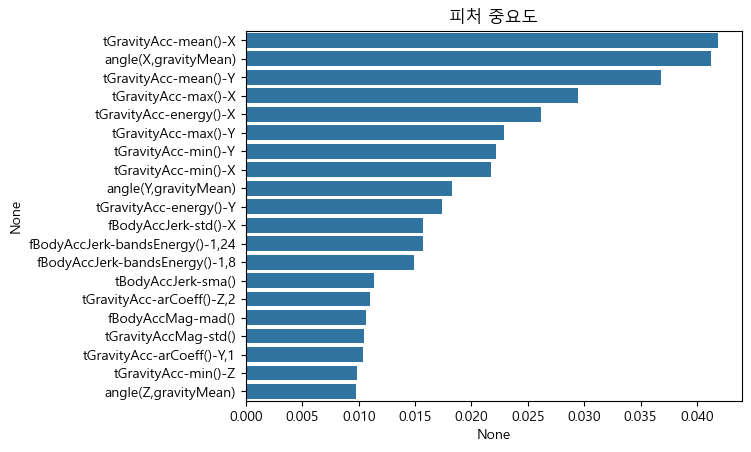

In [50]:
import seaborn as sns
# feature_importances_ 시각화

plt.title('피처 중요도')
sns.barplot(x=feat_top20, y=feat_top20.index)
plt.show()